<a href="https://colab.research.google.com/github/DAWUNHAN/deeplearning-fundamental/blob/master/3_Image/%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5D_%EC%9D%98%EB%A5%98_%EC%A7%81%EB%AC%BC_%EB%B6%88%EB%9F%89_%EA%B2%80%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
- 데이터셋 출처 : AITEX (https://www.aitex.es/afid/)
- [데이터셋 다운로드](https://www.aitex.es/afid/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install opencv-python

In [5]:
import cv2
import os
import glob
import shutil
import random
import string
import numpy as np
import tensorflow as tf

In [3]:
# 이미지 데이터 절대 경로
PATH_DEFECT = '/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Defect_images/'
PATH_NODEFECT = '/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/'

In [8]:
# 이미지 데이터 가져오기 및 라벨링
import os

paths = []
label_divide = []

for dirname, _, filenames in os.walk(PATH_DEFECT):
  for filename in filenames:
    file_path = dirname + filename
    paths.append(file_path)
    label_divide.append('OK')

for dirname, _, filenames in os.walk(PATH_NODEFECT):
  for filename in filenames:
    file_path = dirname+filename
    paths.append(file_path)
    label_divide.append('FAIL')

In [9]:
# 데이터를 dataframe에 담기
import pandas as pd

pd.set_option('display.max_colwidth', 200)

data_df = pd.DataFrame({'path':paths, 'label':label_divide})
print('data_df shape:', data_df.shape)
data_df.tail(5)

data_df shape: (247, 2)


,path,label
242,/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/0015_000_02.png,FAIL
243,/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/0016_000_02.png,FAIL
244,/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/0014_000_02.png,FAIL
245,/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/0013_000_02.png,FAIL
246,/content/drive/MyDrive/Colab Notebooks/data/fabric_factory/Fail_Defect_Images/0011_000_02.png,FAIL


In [11]:
# 데이터 세트값 분포 및 Label 값 분포를 확인한다. 

print(data_df['label'].value_counts())

FAIL    141
OK      106
Name: label, dtype: int64


In [71]:
# 데이터 학습/검정용으로 분리하기

from sklearn.model_selection import train_test_split

# scikit learn의 train_test_split()을 이용하여 train용, validation용 DataFrame을 생성
# stratify를 이용하여 label 값을 균등하게 분할 
tr_df, val_df = train_test_split(data_df, test_size=0.15, stratify=data_df['label'], random_state=2021)
print('tr_df shape:', tr_df.shape, 'val_df shape:', val_df.shape)
print('tr_df label distribution:\n', tr_df['label'].value_counts())
print('val_df label distributuion:\n', val_df['label'].value_counts())

tr_df shape: (209, 2) val_df shape: (38, 2)
tr_df label distribution:
 FAIL    119
OK       90
Name: label, dtype: int64
val_df label distributuion:
 FAIL    22
OK      16
Name: label, dtype: int64


## 이미지 확인
- 육안으로 판별하기는 어렵다.

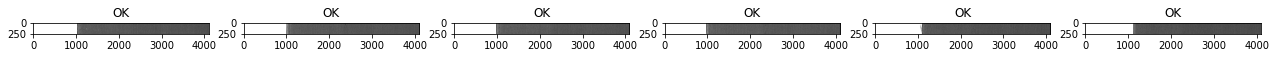

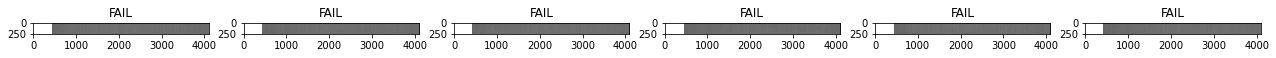

In [13]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def show_grid_images(image_path_list, ncols=8, augmentor=None, title=None):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].set_title(title)  
        
ok_image_list = data_df[data_df['label']=='OK']['path'].iloc[:6].tolist()
show_grid_images(ok_image_list, ncols=6, title='OK')

fail_image_list = data_df[data_df['label']=='FAIL']['path'].iloc[:6].tolist()
show_grid_images(fail_image_list, ncols=6, title='FAIL')

In [18]:
def image_size(image_path, image_label):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    print(image_label, 'image size:', image[:, :, 0].shape)

image_size(ok_image_list[0], 'ok')
image_size(fail_image_list[0], 'fail')

ok image size: (256, 4096)
fail image size: (256, 4096)


# 이미지 생성

In [98]:
# IMAGE 크기와 BATCH 크기를 위한 환경 변수 설정. 
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tr_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.)

tr_flow_gen = tr_generator.flow_from_dataframe(dataframe=tr_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동 Encoding. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=True
                                      )

Found 209 validated image filenames belonging to 2 classes.


In [100]:
images_array = next(tr_flow_gen)[0]
labels_array = next(tr_flow_gen)[1]
print('##### image array shape:', images_array.shape)
print('#### label array shape:', labels_array.shape)

##### image array shape: (32, 224, 224, 3)
#### label array shape: (32,)


In [101]:
# 검증용 ImageDataGenerator는 rescale만 적용. 
val_generator = ImageDataGenerator(rescale=1/255.)
val_flow_gen = val_generator.flow_from_dataframe(dataframe=val_df # image file이 있는 디렉토리
                                      ,x_col='path'
                                      ,y_col='label'
                                      ,target_size=(IMAGE_SIZE, IMAGE_SIZE) # 원본 이미지를 최종 resize할 image size
                                      ,class_mode='binary' # 문자열 label을 자동으로 one-hot encoding 시켜줌. 
                                      ,batch_size=BATCH_SIZE
                                      ,shuffle=False
                                      )

Found 38 validated image filenames belonging to 2 classes.


# 모델 생성

In [104]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [105]:
model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [107]:
# 학습과 검증용 steps_per_epoch 계산 
N_EPOCHS = 5

history = model.fit(tr_flow_gen, epochs=N_EPOCHS,
          steps_per_epoch=int(np.ceil(tr_df.shape[0]/BATCH_SIZE)),
          validation_data=val_flow_gen, 
          validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)), 
          callbacks=[rlr_cb, ely_cb])


Epoch 1/5
7/7 [==============================] - 7s 931ms/step - loss: 0.2900 - accuracy: 0.8804 - val_loss: 0.8102 - val_accuracy: 0.6579 - lr: 2.0000e-04
Epoch 2/5
7/7 [==============================] - 5s 739ms/step - loss: 0.2215 - accuracy: 0.9043 - val_loss: 0.7577 - val_accuracy: 0.7368 - lr: 2.0000e-04
Epoch 3/5
7/7 [==============================] - 6s 772ms/step - loss: 0.1588 - accuracy: 0.9426 - val_loss: 0.6885 - val_accuracy: 0.8421 - lr: 2.0000e-04
Epoch 4/5
7/7 [==============================] - 4s 560ms/step - loss: 0.1710 - accuracy: 0.9378 - val_loss: 0.7997 - val_accuracy: 0.8684 - lr: 2.0000e-04
Epoch 5/5
7/7 [==============================] - 4s 575ms/step - loss: 0.2511 - accuracy: 0.8900 - val_loss: 0.8796 - val_accuracy: 0.8158 - lr: 2.0000e-04


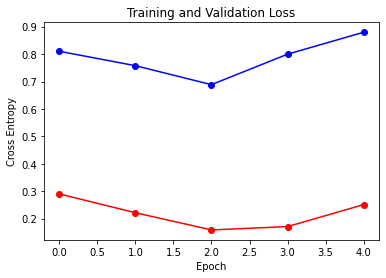

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()